In [1]:
import sys
sys.path.extend(["../..", "../../src"])

In [2]:
from timeit import timeit

from tqdm import tqdm
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import torch as th
from torch.utils.data import TensorDataset


from src.loss import phase_insensitive_loss_cvx
from src.gd_opt import learn_phase_insensitive_povm
from src.quantum import rand_DV_diag_povm, diag_povm_fidelity, get_qubit_probe_states
from src.utils import check_diag_povm
from src.custom_types import Hyperparameters

matplotlib.rcParams.update({"font.size": 16})
plt.rcParams["figure.dpi"] = 125 #200  # set fig resolution
plt.rcParams.update({"text.usetex": True, "font.family": "Helvetica"})

seed = 42  # for reproducibility
th.manual_seed(seed);

In [3]:
def set_batch_size(num_qubits: int, hyperparams: Hyperparameters) -> None:
    if num_qubits < 3:
        hyperparams.batch_size = 2**num_qubits
    elif num_qubits > 7:
        hyperparams.batch_size = 64
    else:
        hyperparams.batch_size = 16

### Time complexity

In [4]:
num_qubits_list = [3, 4, 5, 6, 7, 8, 9, 10]
device = 'cpu'
lam_l1 = 0e-5
number = 5
cco_solver = 'MOSEK'
time_gd = []
time_cco = []
avg_fids_cco = []
iters_cco = []
hyperparams = Hyperparameters(lr=0.01, lr_decay=0.999, beta1=0.9, beta2=0.9, num_epochs=100, batch_size=25)

In [5]:
for num_qubits in tqdm(num_qubits_list, desc="Performing time experiments"):
    set_batch_size(num_qubits, hyperparams)
    
    # Random Z-basis diagonal detector POVM
    true_povm = rand_DV_diag_povm(num_qubits=num_qubits)
    true_povm = th.vstack( [th.diagonal(E) for E in true_povm] ).T.to(device)
    
    # We just need the probs (this only works for kets for dms we'd need to extract the diagonals)
    probes = get_qubit_probe_states(num_qubits, return_dm=False, povm_is_diag=True, device=device).abs() ** 2

    targets = probes @ true_povm  

    M, N, = probes.shape[1], targets.shape[1]
    logits = th.rand((M, N)) - 1
    logits = logits.to(device)
    logits.requires_grad = True

    probes = probes.to(device, dtype=th.float32)
    targets = targets.to(device)
    dataset = TensorDataset(probes, targets)
    
    logits, losses, _, _ = learn_phase_insensitive_povm(logits, hyperparams, dataset, 0.0, False, None, lam_l1)

    Pi = th.softmax(logits, dim=1).to('cpu')  # rows are probability vectors so apply softmax along them
    
    if check_diag_povm(Pi.T, tol=1e-4) is not True:
        print(f"WARNING: Gradient descent got solution POVM for {num_qubits} qubits which is below error tolerance.")

    Fs = [ diag_povm_fidelity(th.diag(Pi[:, i]), true_povm[:, i]) for i in range(true_povm.shape[1]) ]

    
    if num_qubits < 10:
        # skip CVX opt section since the memory usage will be too large and crash the program
        Pi, prob, iters = phase_insensitive_loss_cvx(targets.cpu().numpy(), probes.cpu().numpy(), 0.0, cco_solver, lam_l1)
        Pi = th.tensor(Pi)

        if check_diag_povm(Pi.T, tol=1e-4) is not True:
            print(f"WARNING: {cco_solver} got solution POVM for {num_qubits} qubits which is above error tolerance.")

        iters_cco.append(iters)
        Fs = [ diag_povm_fidelity(Pi[:, i], true_povm[:, i]) for i in range(true_povm.shape[1]) ]
        avg_fids_cco.append(sum(Fs)/len(Fs))

    # compute times
    t = timeit(lambda: learn_phase_insensitive_povm(logits, hyperparams, dataset, 0.0, False, None, lam_l1), number=number)
    time_gd.append(t / number) 
    
    if num_qubits < 10:
        # skip CVX opt section since the memory usage will be too large and crash the program
        t = timeit(lambda: phase_insensitive_loss_cvx(targets.cpu().numpy(), probes.cpu().numpy(), 0.0, cco_solver, lam_l1), number=number) 
        time_cco.append(t / number)

Performing time experiments: 100%|██████████| 8/8 [05:54<00:00, 44.28s/it]


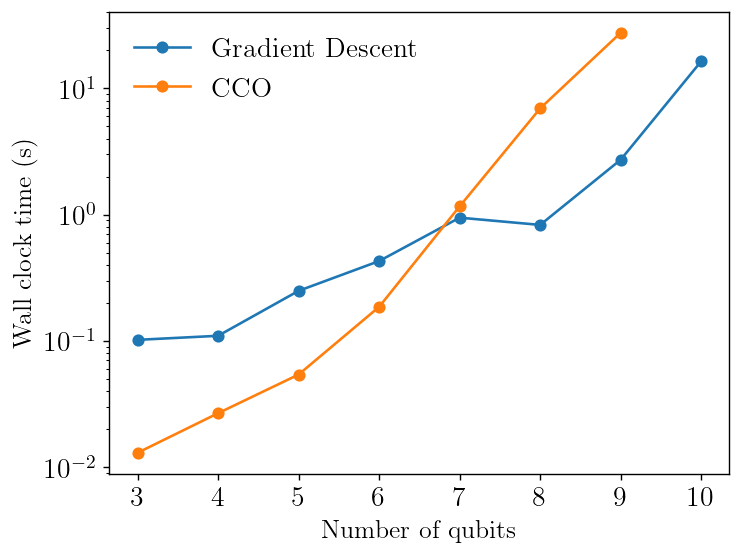

In [6]:
plt.plot(num_qubits_list, time_gd, label=r'\textrm{Gradient Descent}', marker="o")
plt.plot(num_qubits_list[:len(time_cco)], time_cco, label=r'\textrm{CCO}', marker="o")
plt.xlabel(r"\textrm{Number of qubits}", fontsize=15)
plt.xticks(num_qubits_list)
plt.ylabel(r"\textrm{Wall clock time (s)}", fontsize=15)
plt.yscale("log")
plt.legend(fancybox=True, ncol=1, frameon=False)
plt.show();

# if eta < 1.0:
#     plt.savefig("figs/lossy/lossy_wall_clock.png", dpi=300, bbox_inches='tight')
# else:
#     plt.savefig("figs/ideal/ideal_wall_clock.png", dpi=300, bbox_inches='tight')

In [7]:
time_per_iter_gd = [ t/hyperparams.num_epochs for t in time_gd ]

time_per_iter_cco = [ t/iters for t, iters in zip(time_cco, iters_cco) ]

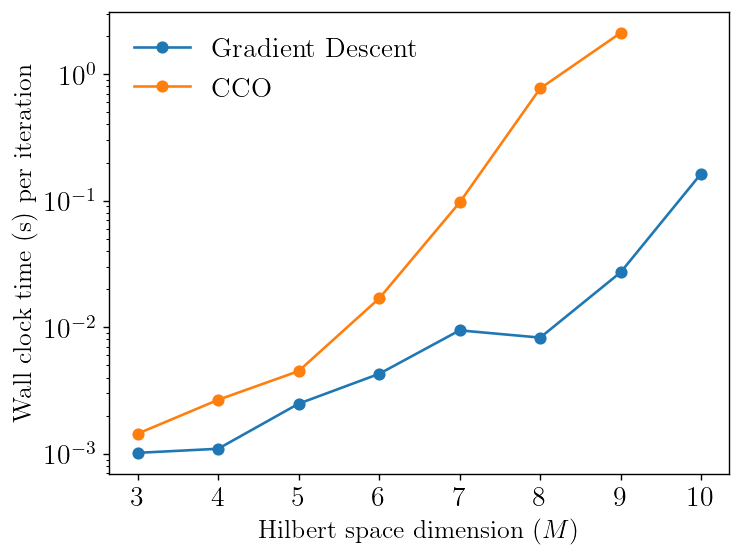

In [8]:
plt.plot(num_qubits_list, time_per_iter_gd, label=r'\textrm{Gradient Descent}', marker="o")
plt.plot(num_qubits_list[:len(time_cco)], time_per_iter_cco, label=r'\textrm{CCO}', marker="o")
plt.xlabel(r"\textrm{Hilbert space dimension} $(M)$", fontsize=15)
plt.xticks(num_qubits_list)
plt.ylabel(r"$\textrm{Wall clock time (s) per iteration}$", fontsize=15)
plt.yscale("log")
plt.legend(fancybox=True, ncol=1, frameon=False)
plt.show();


In [ ]:
gd_trials = 10
avg_fids_gd_sample = []

for num_qubits in tqdm(num_qubits_list, desc="Performing time experiments"):
    set_batch_size(num_qubits, hyperparams)

    avg_fids_gd_M = []
    # Random Z-basis diagonal detector POVM
    true_povm = rand_DV_diag_povm(num_qubits=num_qubits)
    true_povm = th.vstack( [th.diagonal(E) for E in true_povm] ).T

    # We just need the probs (this only works for kets for dms we'd need to extract the diagonals)
    probes = get_qubit_probe_states(num_qubits, return_dm=False, povm_is_diag=True, device=device).abs() ** 2

    targets = probes @ true_povm  
    # `probes` dimension is num probe states x hilbert dim
    # `targets` dimensions is num probes x num povm elements 
    M, N, = probes.shape[1], targets.shape[1]
    
    probes = probes.to(device, dtype=th.float32)
    targets = targets.to(device)
    dataset = TensorDataset(probes, targets)

    for i in range(gd_trials):
        
        logits = th.rand((M, N)) - 1
        logits = logits.to(device)
        logits.requires_grad = True    
        
        logits, losses, _, _ = learn_phase_insensitive_povm(logits, hyperparams, dataset, 0.0, False, None, lam_l1)

        Pi = th.softmax(logits, dim=1).to('cpu')  # rows are probability vectors so apply softmax along them
        
        if check_diag_povm(Pi.T, tol=1e-4) is not True:
            print(f"WARNING: Gradient descent got solution POVM for {num_qubits} qubits which is below error tolerance.")

        Fs = [ diag_povm_fidelity(th.diag(Pi[:, i]), true_povm[:, i]) for i in range(true_povm.shape[1]) ]
        avg_fids_gd_M.append(sum(Fs)/len(Fs))
    
    avg_fids_gd_sample.append(avg_fids_gd_M)

Performing time experiments: 100%|██████████| 8/8 [03:49<00:00, 28.66s/it]


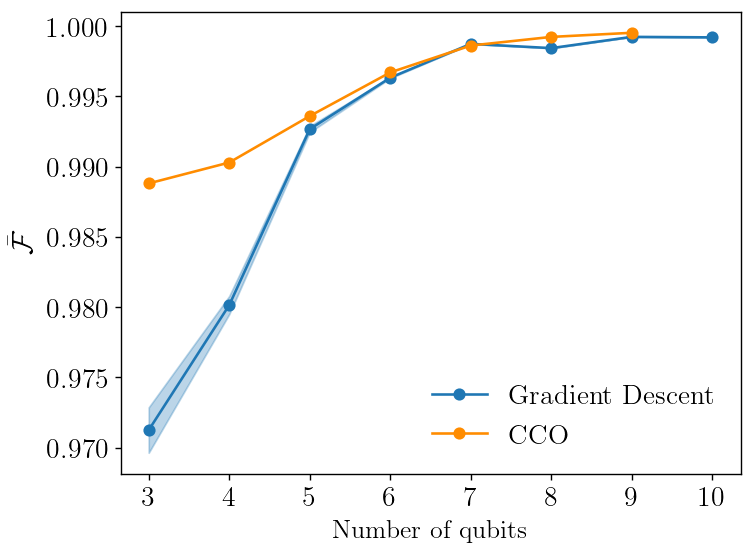

In [10]:
arr = np.array(avg_fids_gd_sample)
mean = arr.mean(axis=1)
lower = mean - np.std(arr, axis=1)
upper = mean + np.std(arr, axis=1)

plt.plot(num_qubits_list, mean, color='C0', label=r'\textrm{Gradient Descent}', marker="o")
plt.fill_between(num_qubits_list, lower, upper, color='C0', alpha=0.3)
plt.plot(num_qubits_list[:len(avg_fids_cco)], avg_fids_cco, label=r'\textrm{CCO}', marker="o", color="darkorange")

plt.xlabel(r"\textrm{Number of qubits}", fontsize=15)
plt.xticks(num_qubits_list)
plt.ylabel(r"$\bar{\mathcal{F}}$", fontsize=17.0)
# plt.yscale("log")

plt.legend(fancybox=True, ncol=1, frameon=False)
plt.show();